# Part 3 Feature Selection 


### Goal: 
Use 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90%, and 100% of randomly selecteed features to train the neural network and test on it respectively. You build 9 systems. Plot a graph where the x-axis indicates the percentage of features you used to train a system, and the y-axis indicate the accuracy on the test set of each system 

In [1]:
import warnings 
warnings.filterwarnings('ignore')

import h5py
import numpy as np
import matplotlib.pyplot as plt 

import sklearn 
from sklearn import datasets
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.utils import to_categorical
from keras import layers
from keras import models 
from keras.layers import Dense
from keras import optimizers 
from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
import math

import tensorflow as tf

Using TensorFlow backend.


In [2]:
def dataCollection(): 
    print("Data Collection")
    wine = sklearn.datasets.load_wine()
    
    df = pd.DataFrame(wine.data)
    df.columns = wine.feature_names
    df["class"] = wine.target
    
    labels = df.loc[:,["class"]] 
    features = df.drop(["class"],axis=1)
    
    return features, labels

Discussion:     
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; While there are various types of feature selection and dimensionalty reduction, I chose to use a type of feature selection called recursive feature elimination (RFE) which works by recursively removing attributes and building a model on those attributes that remain. I chose to use a random forest classifier to identify attributes contribute the most to predicting the labels.      
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; The number of features to select by the RFE is determined by multiplying the percentage to the total number of features in the dataset(13)

In [3]:
def rfe(percentage, features, labels): 
    '''
    Applies recursive feature elimination to find percentage of features to use 
    Returns selected features 
    '''
    print("RFE")
    rfc = RandomForestClassifier(random_state = 101)
    
    # Number of features to select is the percentage given * total features - rounded 
    rfe = RFE(rfc, n_features_to_select = math.floor(percentage*13))
    fit = rfe.fit(features, labels)
    
    print("Number of Features", fit.n_features_)
    print("Ranking of Features", fit.ranking_)
    print("Selected Features", fit.support_)
    
    # selected features from original dataset  
    features = features.loc[:, list(fit.support_)] 
    
    return features 

In [4]:
def dataPrep(features, labels):
    '''
    Prepares features and labels into its respective sets 
    '''
    print("dataPrep")
    xtrain, xtest, ytrain, ytest = train_test_split(features, labels)
    
    #convert labels to categorical 
    ytrain = to_categorical(ytrain, 3)
    ytest = to_categorical(ytest,3)
    
    # Scale data 
    scale = MinMaxScaler(feature_range=(0,1))
    xtrain = scale.fit_transform(xtrain)
    xtest = scale.fit_transform(xtest)
    return xtrain, xtest, ytrain, ytest 

In [5]:
def trainModel(xtrain, ytrain):
    '''
    Builds and runs training model 
    '''
    print("Training the Model")
    
    model = Sequential()
    model.add(Dense(10, input_dim=xtrain.shape[1],activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(6, activation='relu'))
    model.add(Dense(6, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(loss="categorical_crossentropy", optimizer = optimizers.RMSprop(lr = 1e-3), metrics = ["acc"])
    
    # Save weights 
    checkpoint = ModelCheckpoint("model_part3.hdf5", monitor="loss", verbose=1, save_best_only = True, mode="auto", period=1)
    
    # Apply early stopping to prevent overfitting 
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto',restore_best_weights=True)
    
    # Run Model 
    history = model.fit(xtrain, ytrain, batch_size=50, epochs=2000, verbose =0, validation_split=0.3, callbacks=[checkpoint,monitor])
    

In [6]:
def testModel(xtest, ytest): 
    '''
    Builds and runs testing model 
    '''
    print("Testing the model")
    
    evalModel = Sequential()
    evalModel.add(Dense(10, input_dim=xtest.shape[1],activation='relu'))
    evalModel.add(Dense(8, activation='relu'))
    evalModel.add(Dense(6, activation='relu'))
    evalModel.add(Dense(6, activation='relu'))
    evalModel.add(Dense(4, activation='relu'))
    evalModel.add(Dense(3, activation='softmax'))


    evalModel.load_weights('model_part3.hdf5')
    evalModel.compile(loss="categorical_crossentropy", optimizer = optimizers.RMSprop(lr = 1e-3), metrics = ["acc"])
    
    lossAndAcc = evalModel.evaluate(xtest, ytest)

    return lossAndAcc[1]

In [7]:
def main(percent_features, accuracy): 
    '''
    Driver for program 
    '''
    features, labels = dataCollection()
   
    for i in range(len(percent_features)): 
        print("====================================================")
        print("Percent Features ", percent_features[i])
 
        # Call Recursive Feature Elimation given percent features 
        new_features = rfe(percent_features[i], features, labels)
        
        # Split features and labels 
        xtrain, xtest, ytrain, ytest = dataPrep(new_features, labels)
        
        # Train Model 
        trainModel(xtrain, ytrain)
        
        # Test Model
        curr_acc = testModel(xtest, ytest)
        
        # Add accuracy to our list 
        accuracy.append(curr_acc)
        
        print("====================================================\n")

    
    return accuracy


In [8]:
percent_features = [0.20, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
accuracy = []

acc = main(percent_features, accuracy)

Data Collection
Percent Features  0.2
RFE
Number of Features 2
Ranking of Features [ 4  8 11  9  7  6  1 12 10  1  5  3  2]
Selected Features [False False False False False False  True False False  True False False
 False]
dataPrep
Training the Model
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.

Epoch 00001: loss improved from inf to 1.10040, saving model to model_part3.hdf5

Epoch 00002: loss improved from 1.10040 to 1.09740, saving model to model_part3.hdf5

Epoch 00003: loss improved from 1.09740 to 1.09589, saving model to model_part3.hdf5

Epoch 00004: loss improved from 1.09589 to 1.09468, saving model to model_part3.hdf5

Epoch 00005: loss improved from 1.09468 to 1.09401, saving model to model_part3.hdf5

Epoch 00006: loss improved from 1.09401 to 1.09343, saving model to model_part3.hdf5

Epoch 00007: loss improved from 1.09343 to 1.09255, saving model to model_part3.hdf5

Epoch 00008: loss improved fro


Epoch 00091: loss improved from 0.89894 to 0.89462, saving model to model_part3.hdf5

Epoch 00092: loss improved from 0.89462 to 0.88961, saving model to model_part3.hdf5

Epoch 00093: loss improved from 0.88961 to 0.88568, saving model to model_part3.hdf5

Epoch 00094: loss improved from 0.88568 to 0.88139, saving model to model_part3.hdf5

Epoch 00095: loss improved from 0.88139 to 0.87649, saving model to model_part3.hdf5

Epoch 00096: loss improved from 0.87649 to 0.87189, saving model to model_part3.hdf5

Epoch 00097: loss improved from 0.87189 to 0.86717, saving model to model_part3.hdf5

Epoch 00098: loss improved from 0.86717 to 0.86253, saving model to model_part3.hdf5

Epoch 00099: loss improved from 0.86253 to 0.85967, saving model to model_part3.hdf5

Epoch 00100: loss improved from 0.85967 to 0.85330, saving model to model_part3.hdf5

Epoch 00101: loss improved from 0.85330 to 0.84974, saving model to model_part3.hdf5

Epoch 00102: loss improved from 0.84974 to 0.84429, s

Number of Features 3
Ranking of Features [ 3  7 10  8  6  5  1 11  9  1  4  2  1]
Selected Features [False False False False False False  True False False  True False False
  True]
dataPrep
Training the Model

Epoch 00001: loss improved from inf to 1.10206, saving model to model_part3.hdf5

Epoch 00002: loss improved from 1.10206 to 1.09995, saving model to model_part3.hdf5

Epoch 00003: loss improved from 1.09995 to 1.09864, saving model to model_part3.hdf5

Epoch 00004: loss improved from 1.09864 to 1.09801, saving model to model_part3.hdf5

Epoch 00005: loss improved from 1.09801 to 1.09688, saving model to model_part3.hdf5

Epoch 00006: loss improved from 1.09688 to 1.09637, saving model to model_part3.hdf5

Epoch 00007: loss improved from 1.09637 to 1.09558, saving model to model_part3.hdf5

Epoch 00008: loss improved from 1.09558 to 1.09503, saving model to model_part3.hdf5

Epoch 00009: loss improved from 1.09503 to 1.09447, saving model to model_part3.hdf5

Epoch 00010: loss im


Epoch 00100: loss improved from 0.90881 to 0.90493, saving model to model_part3.hdf5

Epoch 00101: loss improved from 0.90493 to 0.90093, saving model to model_part3.hdf5

Epoch 00102: loss improved from 0.90093 to 0.89646, saving model to model_part3.hdf5

Epoch 00103: loss improved from 0.89646 to 0.89301, saving model to model_part3.hdf5

Epoch 00104: loss improved from 0.89301 to 0.88857, saving model to model_part3.hdf5

Epoch 00105: loss improved from 0.88857 to 0.88450, saving model to model_part3.hdf5

Epoch 00106: loss improved from 0.88450 to 0.88072, saving model to model_part3.hdf5

Epoch 00107: loss improved from 0.88072 to 0.87668, saving model to model_part3.hdf5

Epoch 00108: loss improved from 0.87668 to 0.87252, saving model to model_part3.hdf5

Epoch 00109: loss improved from 0.87252 to 0.86848, saving model to model_part3.hdf5

Epoch 00110: loss improved from 0.86848 to 0.86469, saving model to model_part3.hdf5

Epoch 00111: loss improved from 0.86469 to 0.86092, s


Epoch 00196: loss improved from 0.68296 to 0.68164, saving model to model_part3.hdf5

Epoch 00197: loss improved from 0.68164 to 0.68057, saving model to model_part3.hdf5

Epoch 00198: loss improved from 0.68057 to 0.67894, saving model to model_part3.hdf5

Epoch 00199: loss improved from 0.67894 to 0.67763, saving model to model_part3.hdf5

Epoch 00200: loss improved from 0.67763 to 0.67637, saving model to model_part3.hdf5

Epoch 00201: loss improved from 0.67637 to 0.67528, saving model to model_part3.hdf5

Epoch 00202: loss improved from 0.67528 to 0.67369, saving model to model_part3.hdf5

Epoch 00203: loss improved from 0.67369 to 0.67297, saving model to model_part3.hdf5

Epoch 00204: loss improved from 0.67297 to 0.67100, saving model to model_part3.hdf5

Epoch 00205: loss improved from 0.67100 to 0.67020, saving model to model_part3.hdf5

Epoch 00206: loss improved from 0.67020 to 0.66916, saving model to model_part3.hdf5

Epoch 00207: loss improved from 0.66916 to 0.66709, s


Epoch 00294: loss improved from 0.42451 to 0.42111, saving model to model_part3.hdf5

Epoch 00295: loss improved from 0.42111 to 0.41683, saving model to model_part3.hdf5

Epoch 00296: loss improved from 0.41683 to 0.41288, saving model to model_part3.hdf5

Epoch 00297: loss improved from 0.41288 to 0.40921, saving model to model_part3.hdf5

Epoch 00298: loss improved from 0.40921 to 0.40640, saving model to model_part3.hdf5

Epoch 00299: loss improved from 0.40640 to 0.40373, saving model to model_part3.hdf5

Epoch 00300: loss improved from 0.40373 to 0.39802, saving model to model_part3.hdf5

Epoch 00301: loss improved from 0.39802 to 0.39448, saving model to model_part3.hdf5

Epoch 00302: loss improved from 0.39448 to 0.39191, saving model to model_part3.hdf5

Epoch 00303: loss improved from 0.39191 to 0.38917, saving model to model_part3.hdf5

Epoch 00304: loss improved from 0.38917 to 0.38383, saving model to model_part3.hdf5

Epoch 00305: loss improved from 0.38383 to 0.37995, s


Epoch 00394: loss improved from 0.13785 to 0.13647, saving model to model_part3.hdf5

Epoch 00395: loss improved from 0.13647 to 0.13473, saving model to model_part3.hdf5

Epoch 00396: loss improved from 0.13473 to 0.13289, saving model to model_part3.hdf5

Epoch 00397: loss improved from 0.13289 to 0.13165, saving model to model_part3.hdf5

Epoch 00398: loss did not improve from 0.13165

Epoch 00399: loss improved from 0.13165 to 0.12766, saving model to model_part3.hdf5

Epoch 00400: loss improved from 0.12766 to 0.12605, saving model to model_part3.hdf5

Epoch 00401: loss improved from 0.12605 to 0.12469, saving model to model_part3.hdf5

Epoch 00402: loss improved from 0.12469 to 0.12288, saving model to model_part3.hdf5

Epoch 00403: loss did not improve from 0.12288

Epoch 00404: loss improved from 0.12288 to 0.11971, saving model to model_part3.hdf5

Epoch 00405: loss did not improve from 0.11971

Epoch 00406: loss did not improve from 0.11971

Epoch 00407: loss improved from 0


Epoch 00057: loss improved from 0.92899 to 0.92434, saving model to model_part3.hdf5

Epoch 00058: loss improved from 0.92434 to 0.91992, saving model to model_part3.hdf5

Epoch 00059: loss improved from 0.91992 to 0.91565, saving model to model_part3.hdf5

Epoch 00060: loss improved from 0.91565 to 0.91161, saving model to model_part3.hdf5

Epoch 00061: loss improved from 0.91161 to 0.90705, saving model to model_part3.hdf5

Epoch 00062: loss improved from 0.90705 to 0.90227, saving model to model_part3.hdf5

Epoch 00063: loss improved from 0.90227 to 0.89767, saving model to model_part3.hdf5

Epoch 00064: loss improved from 0.89767 to 0.89401, saving model to model_part3.hdf5

Epoch 00065: loss improved from 0.89401 to 0.88883, saving model to model_part3.hdf5

Epoch 00066: loss improved from 0.88883 to 0.88464, saving model to model_part3.hdf5

Epoch 00067: loss improved from 0.88464 to 0.88062, saving model to model_part3.hdf5

Epoch 00068: loss improved from 0.88062 to 0.87561, s


Epoch 00160: loss improved from 0.61147 to 0.60926, saving model to model_part3.hdf5

Epoch 00161: loss improved from 0.60926 to 0.60777, saving model to model_part3.hdf5

Epoch 00162: loss improved from 0.60777 to 0.60500, saving model to model_part3.hdf5

Epoch 00163: loss improved from 0.60500 to 0.60244, saving model to model_part3.hdf5

Epoch 00164: loss improved from 0.60244 to 0.60007, saving model to model_part3.hdf5

Epoch 00165: loss improved from 0.60007 to 0.59854, saving model to model_part3.hdf5

Epoch 00166: loss improved from 0.59854 to 0.59626, saving model to model_part3.hdf5

Epoch 00167: loss improved from 0.59626 to 0.59355, saving model to model_part3.hdf5

Epoch 00168: loss improved from 0.59355 to 0.59201, saving model to model_part3.hdf5

Epoch 00169: loss improved from 0.59201 to 0.59079, saving model to model_part3.hdf5

Epoch 00170: loss improved from 0.59079 to 0.58729, saving model to model_part3.hdf5

Epoch 00171: loss improved from 0.58729 to 0.58522, s


Epoch 00260: loss improved from 0.38888 to 0.38742, saving model to model_part3.hdf5

Epoch 00261: loss improved from 0.38742 to 0.38431, saving model to model_part3.hdf5

Epoch 00262: loss improved from 0.38431 to 0.38297, saving model to model_part3.hdf5

Epoch 00263: loss improved from 0.38297 to 0.37968, saving model to model_part3.hdf5

Epoch 00264: loss improved from 0.37968 to 0.37739, saving model to model_part3.hdf5

Epoch 00265: loss improved from 0.37739 to 0.37606, saving model to model_part3.hdf5

Epoch 00266: loss improved from 0.37606 to 0.37321, saving model to model_part3.hdf5

Epoch 00267: loss improved from 0.37321 to 0.37015, saving model to model_part3.hdf5

Epoch 00268: loss did not improve from 0.37015

Epoch 00269: loss improved from 0.37015 to 0.36570, saving model to model_part3.hdf5

Epoch 00270: loss improved from 0.36570 to 0.36445, saving model to model_part3.hdf5

Epoch 00271: loss improved from 0.36445 to 0.36309, saving model to model_part3.hdf5

Epoch


Epoch 00364: loss improved from 0.21726 to 0.21624, saving model to model_part3.hdf5

Epoch 00365: loss improved from 0.21624 to 0.21492, saving model to model_part3.hdf5

Epoch 00366: loss did not improve from 0.21492

Epoch 00367: loss improved from 0.21492 to 0.21382, saving model to model_part3.hdf5

Epoch 00368: loss improved from 0.21382 to 0.21248, saving model to model_part3.hdf5

Epoch 00369: loss improved from 0.21248 to 0.21140, saving model to model_part3.hdf5

Epoch 00370: loss improved from 0.21140 to 0.21085, saving model to model_part3.hdf5

Epoch 00371: loss improved from 0.21085 to 0.21007, saving model to model_part3.hdf5

Epoch 00372: loss improved from 0.21007 to 0.20769, saving model to model_part3.hdf5

Epoch 00373: loss improved from 0.20769 to 0.20685, saving model to model_part3.hdf5

Epoch 00374: loss improved from 0.20685 to 0.20578, saving model to model_part3.hdf5

Epoch 00375: loss improved from 0.20578 to 0.20457, saving model to model_part3.hdf5

Epoch


Epoch 00037: loss improved from 0.97058 to 0.96692, saving model to model_part3.hdf5

Epoch 00038: loss improved from 0.96692 to 0.96236, saving model to model_part3.hdf5

Epoch 00039: loss improved from 0.96236 to 0.95773, saving model to model_part3.hdf5

Epoch 00040: loss improved from 0.95773 to 0.95315, saving model to model_part3.hdf5

Epoch 00041: loss improved from 0.95315 to 0.94930, saving model to model_part3.hdf5

Epoch 00042: loss improved from 0.94930 to 0.94467, saving model to model_part3.hdf5

Epoch 00043: loss improved from 0.94467 to 0.94078, saving model to model_part3.hdf5

Epoch 00044: loss improved from 0.94078 to 0.93734, saving model to model_part3.hdf5

Epoch 00045: loss improved from 0.93734 to 0.93116, saving model to model_part3.hdf5

Epoch 00046: loss improved from 0.93116 to 0.92685, saving model to model_part3.hdf5

Epoch 00047: loss improved from 0.92685 to 0.92206, saving model to model_part3.hdf5

Epoch 00048: loss improved from 0.92206 to 0.91748, s


Epoch 00137: loss improved from 0.54351 to 0.54106, saving model to model_part3.hdf5

Epoch 00138: loss improved from 0.54106 to 0.53617, saving model to model_part3.hdf5

Epoch 00139: loss improved from 0.53617 to 0.53247, saving model to model_part3.hdf5

Epoch 00140: loss improved from 0.53247 to 0.52938, saving model to model_part3.hdf5

Epoch 00141: loss improved from 0.52938 to 0.52707, saving model to model_part3.hdf5

Epoch 00142: loss improved from 0.52707 to 0.52135, saving model to model_part3.hdf5

Epoch 00143: loss improved from 0.52135 to 0.51793, saving model to model_part3.hdf5

Epoch 00144: loss improved from 0.51793 to 0.51515, saving model to model_part3.hdf5

Epoch 00145: loss improved from 0.51515 to 0.51203, saving model to model_part3.hdf5

Epoch 00146: loss improved from 0.51203 to 0.50739, saving model to model_part3.hdf5

Epoch 00147: loss improved from 0.50739 to 0.50423, saving model to model_part3.hdf5

Epoch 00148: loss improved from 0.50423 to 0.50082, s


Epoch 00240: loss did not improve from 0.28077

Epoch 00241: loss improved from 0.28077 to 0.27876, saving model to model_part3.hdf5

Epoch 00242: loss improved from 0.27876 to 0.27662, saving model to model_part3.hdf5

Epoch 00243: loss improved from 0.27662 to 0.27455, saving model to model_part3.hdf5

Epoch 00244: loss did not improve from 0.27455

Epoch 00245: loss improved from 0.27455 to 0.27350, saving model to model_part3.hdf5

Epoch 00246: loss improved from 0.27350 to 0.27084, saving model to model_part3.hdf5

Epoch 00247: loss improved from 0.27084 to 0.26807, saving model to model_part3.hdf5

Epoch 00248: loss improved from 0.26807 to 0.26733, saving model to model_part3.hdf5

Epoch 00249: loss improved from 0.26733 to 0.26648, saving model to model_part3.hdf5

Epoch 00250: loss improved from 0.26648 to 0.26348, saving model to model_part3.hdf5

Epoch 00251: loss improved from 0.26348 to 0.26184, saving model to model_part3.hdf5

Epoch 00252: loss improved from 0.26184 to 


Epoch 00344: loss did not improve from 0.10216

Epoch 00345: loss improved from 0.10216 to 0.09974, saving model to model_part3.hdf5

Epoch 00346: loss improved from 0.09974 to 0.09778, saving model to model_part3.hdf5

Epoch 00347: loss did not improve from 0.09778

Epoch 00348: loss improved from 0.09778 to 0.09553, saving model to model_part3.hdf5

Epoch 00349: loss improved from 0.09553 to 0.09314, saving model to model_part3.hdf5

Epoch 00350: loss improved from 0.09314 to 0.09143, saving model to model_part3.hdf5

Epoch 00351: loss improved from 0.09143 to 0.08990, saving model to model_part3.hdf5

Epoch 00352: loss improved from 0.08990 to 0.08878, saving model to model_part3.hdf5

Epoch 00353: loss improved from 0.08878 to 0.08653, saving model to model_part3.hdf5

Epoch 00354: loss improved from 0.08653 to 0.08625, saving model to model_part3.hdf5

Epoch 00355: loss improved from 0.08625 to 0.08466, saving model to model_part3.hdf5

Epoch 00356: loss did not improve from 0.08


Epoch 00026: loss improved from 1.07300 to 1.07113, saving model to model_part3.hdf5

Epoch 00027: loss improved from 1.07113 to 1.06934, saving model to model_part3.hdf5

Epoch 00028: loss improved from 1.06934 to 1.06753, saving model to model_part3.hdf5

Epoch 00029: loss improved from 1.06753 to 1.06551, saving model to model_part3.hdf5

Epoch 00030: loss improved from 1.06551 to 1.06352, saving model to model_part3.hdf5

Epoch 00031: loss improved from 1.06352 to 1.06140, saving model to model_part3.hdf5

Epoch 00032: loss improved from 1.06140 to 1.05919, saving model to model_part3.hdf5

Epoch 00033: loss improved from 1.05919 to 1.05728, saving model to model_part3.hdf5

Epoch 00034: loss improved from 1.05728 to 1.05557, saving model to model_part3.hdf5

Epoch 00035: loss improved from 1.05557 to 1.05315, saving model to model_part3.hdf5

Epoch 00036: loss improved from 1.05315 to 1.05080, saving model to model_part3.hdf5

Epoch 00037: loss improved from 1.05080 to 1.04900, s


Epoch 00127: loss improved from 0.51803 to 0.51183, saving model to model_part3.hdf5

Epoch 00128: loss improved from 0.51183 to 0.50703, saving model to model_part3.hdf5

Epoch 00129: loss improved from 0.50703 to 0.50003, saving model to model_part3.hdf5

Epoch 00130: loss improved from 0.50003 to 0.49306, saving model to model_part3.hdf5

Epoch 00131: loss improved from 0.49306 to 0.48677, saving model to model_part3.hdf5

Epoch 00132: loss improved from 0.48677 to 0.48190, saving model to model_part3.hdf5

Epoch 00133: loss improved from 0.48190 to 0.47429, saving model to model_part3.hdf5

Epoch 00134: loss improved from 0.47429 to 0.46760, saving model to model_part3.hdf5

Epoch 00135: loss improved from 0.46760 to 0.46360, saving model to model_part3.hdf5

Epoch 00136: loss improved from 0.46360 to 0.45810, saving model to model_part3.hdf5

Epoch 00137: loss improved from 0.45810 to 0.45401, saving model to model_part3.hdf5

Epoch 00138: loss improved from 0.45401 to 0.44524, s


Epoch 00230: loss improved from 0.11954 to 0.11789, saving model to model_part3.hdf5

Epoch 00231: loss improved from 0.11789 to 0.11680, saving model to model_part3.hdf5

Epoch 00232: loss improved from 0.11680 to 0.11353, saving model to model_part3.hdf5

Epoch 00233: loss improved from 0.11353 to 0.11189, saving model to model_part3.hdf5

Epoch 00234: loss improved from 0.11189 to 0.10965, saving model to model_part3.hdf5

Epoch 00235: loss improved from 0.10965 to 0.10867, saving model to model_part3.hdf5

Epoch 00236: loss did not improve from 0.10867

Epoch 00237: loss improved from 0.10867 to 0.10733, saving model to model_part3.hdf5

Epoch 00238: loss improved from 0.10733 to 0.10586, saving model to model_part3.hdf5

Epoch 00239: loss improved from 0.10586 to 0.10202, saving model to model_part3.hdf5

Epoch 00240: loss did not improve from 0.10202
Testing the model
45/45 [==============================] - 0s 1ms/step

Percent Features  0.7
RFE
Number of Features 9
Ranking of 


Epoch 00085: loss did not improve from 0.73849

Epoch 00086: loss improved from 0.73849 to 0.73170, saving model to model_part3.hdf5

Epoch 00087: loss improved from 0.73170 to 0.72796, saving model to model_part3.hdf5

Epoch 00088: loss improved from 0.72796 to 0.72518, saving model to model_part3.hdf5

Epoch 00089: loss improved from 0.72518 to 0.72186, saving model to model_part3.hdf5

Epoch 00090: loss improved from 0.72186 to 0.71804, saving model to model_part3.hdf5

Epoch 00091: loss improved from 0.71804 to 0.71704, saving model to model_part3.hdf5

Epoch 00092: loss improved from 0.71704 to 0.71422, saving model to model_part3.hdf5

Epoch 00093: loss improved from 0.71422 to 0.70964, saving model to model_part3.hdf5

Epoch 00094: loss improved from 0.70964 to 0.70513, saving model to model_part3.hdf5

Epoch 00095: loss improved from 0.70513 to 0.70193, saving model to model_part3.hdf5

Epoch 00096: loss improved from 0.70193 to 0.69969, saving model to model_part3.hdf5

Epoch


Epoch 00185: loss improved from 0.47730 to 0.47305, saving model to model_part3.hdf5

Epoch 00186: loss improved from 0.47305 to 0.47042, saving model to model_part3.hdf5

Epoch 00187: loss improved from 0.47042 to 0.46838, saving model to model_part3.hdf5

Epoch 00188: loss improved from 0.46838 to 0.46710, saving model to model_part3.hdf5

Epoch 00189: loss improved from 0.46710 to 0.46475, saving model to model_part3.hdf5

Epoch 00190: loss did not improve from 0.46475

Epoch 00191: loss improved from 0.46475 to 0.45886, saving model to model_part3.hdf5

Epoch 00192: loss improved from 0.45886 to 0.45833, saving model to model_part3.hdf5

Epoch 00193: loss improved from 0.45833 to 0.45730, saving model to model_part3.hdf5

Epoch 00194: loss improved from 0.45730 to 0.45287, saving model to model_part3.hdf5

Epoch 00195: loss improved from 0.45287 to 0.45146, saving model to model_part3.hdf5

Epoch 00196: loss improved from 0.45146 to 0.44790, saving model to model_part3.hdf5

Epoch


Epoch 00289: loss improved from 0.25818 to 0.25550, saving model to model_part3.hdf5

Epoch 00290: loss improved from 0.25550 to 0.25461, saving model to model_part3.hdf5

Epoch 00291: loss improved from 0.25461 to 0.25321, saving model to model_part3.hdf5

Epoch 00292: loss improved from 0.25321 to 0.25062, saving model to model_part3.hdf5

Epoch 00293: loss improved from 0.25062 to 0.24882, saving model to model_part3.hdf5

Epoch 00294: loss improved from 0.24882 to 0.24764, saving model to model_part3.hdf5

Epoch 00295: loss improved from 0.24764 to 0.24580, saving model to model_part3.hdf5

Epoch 00296: loss improved from 0.24580 to 0.24451, saving model to model_part3.hdf5

Epoch 00297: loss improved from 0.24451 to 0.24448, saving model to model_part3.hdf5

Epoch 00298: loss improved from 0.24448 to 0.24166, saving model to model_part3.hdf5

Epoch 00299: loss improved from 0.24166 to 0.23895, saving model to model_part3.hdf5

Epoch 00300: loss did not improve from 0.23895

Epoch


Epoch 00070: loss improved from 0.59011 to 0.58024, saving model to model_part3.hdf5

Epoch 00071: loss improved from 0.58024 to 0.57277, saving model to model_part3.hdf5

Epoch 00072: loss improved from 0.57277 to 0.56233, saving model to model_part3.hdf5

Epoch 00073: loss improved from 0.56233 to 0.55231, saving model to model_part3.hdf5

Epoch 00074: loss improved from 0.55231 to 0.54269, saving model to model_part3.hdf5

Epoch 00075: loss improved from 0.54269 to 0.53367, saving model to model_part3.hdf5

Epoch 00076: loss improved from 0.53367 to 0.52369, saving model to model_part3.hdf5

Epoch 00077: loss improved from 0.52369 to 0.51562, saving model to model_part3.hdf5

Epoch 00078: loss improved from 0.51562 to 0.50527, saving model to model_part3.hdf5

Epoch 00079: loss improved from 0.50527 to 0.49841, saving model to model_part3.hdf5

Epoch 00080: loss improved from 0.49841 to 0.48716, saving model to model_part3.hdf5

Epoch 00081: loss improved from 0.48716 to 0.47846, s


Epoch 00172: loss improved from 0.07463 to 0.07377, saving model to model_part3.hdf5

Epoch 00173: loss improved from 0.07377 to 0.07265, saving model to model_part3.hdf5

Epoch 00174: loss improved from 0.07265 to 0.07056, saving model to model_part3.hdf5

Epoch 00175: loss did not improve from 0.07056

Epoch 00176: loss improved from 0.07056 to 0.06858, saving model to model_part3.hdf5

Epoch 00177: loss improved from 0.06858 to 0.06750, saving model to model_part3.hdf5

Epoch 00178: loss improved from 0.06750 to 0.06614, saving model to model_part3.hdf5

Epoch 00179: loss did not improve from 0.06614

Epoch 00180: loss improved from 0.06614 to 0.06299, saving model to model_part3.hdf5

Epoch 00181: loss improved from 0.06299 to 0.06164, saving model to model_part3.hdf5

Epoch 00182: loss improved from 0.06164 to 0.06060, saving model to model_part3.hdf5

Epoch 00183: loss did not improve from 0.06060

Epoch 00184: loss did not improve from 0.06060

Epoch 00185: loss improved from 0


Epoch 00080: loss improved from 0.87039 to 0.86595, saving model to model_part3.hdf5

Epoch 00081: loss improved from 0.86595 to 0.86215, saving model to model_part3.hdf5

Epoch 00082: loss improved from 0.86215 to 0.85902, saving model to model_part3.hdf5

Epoch 00083: loss improved from 0.85902 to 0.85451, saving model to model_part3.hdf5

Epoch 00084: loss improved from 0.85451 to 0.85269, saving model to model_part3.hdf5

Epoch 00085: loss improved from 0.85269 to 0.84750, saving model to model_part3.hdf5

Epoch 00086: loss improved from 0.84750 to 0.84353, saving model to model_part3.hdf5

Epoch 00087: loss improved from 0.84353 to 0.84006, saving model to model_part3.hdf5

Epoch 00088: loss improved from 0.84006 to 0.83658, saving model to model_part3.hdf5

Epoch 00089: loss improved from 0.83658 to 0.83332, saving model to model_part3.hdf5

Epoch 00090: loss improved from 0.83332 to 0.82953, saving model to model_part3.hdf5

Epoch 00091: loss improved from 0.82953 to 0.82595, s


Epoch 00022: loss improved from 0.96677 to 0.96237, saving model to model_part3.hdf5

Epoch 00023: loss improved from 0.96237 to 0.95874, saving model to model_part3.hdf5

Epoch 00024: loss improved from 0.95874 to 0.95399, saving model to model_part3.hdf5

Epoch 00025: loss improved from 0.95399 to 0.94974, saving model to model_part3.hdf5

Epoch 00026: loss improved from 0.94974 to 0.94609, saving model to model_part3.hdf5

Epoch 00027: loss improved from 0.94609 to 0.94048, saving model to model_part3.hdf5

Epoch 00028: loss improved from 0.94048 to 0.93566, saving model to model_part3.hdf5

Epoch 00029: loss improved from 0.93566 to 0.93084, saving model to model_part3.hdf5

Epoch 00030: loss improved from 0.93084 to 0.92696, saving model to model_part3.hdf5

Epoch 00031: loss improved from 0.92696 to 0.92288, saving model to model_part3.hdf5

Epoch 00032: loss improved from 0.92288 to 0.91702, saving model to model_part3.hdf5

Epoch 00033: loss improved from 0.91702 to 0.91300, s


Epoch 00128: loss improved from 0.56411 to 0.56327, saving model to model_part3.hdf5

Epoch 00129: loss improved from 0.56327 to 0.56135, saving model to model_part3.hdf5

Epoch 00130: loss improved from 0.56135 to 0.55666, saving model to model_part3.hdf5

Epoch 00131: loss improved from 0.55666 to 0.55109, saving model to model_part3.hdf5

Epoch 00132: loss improved from 0.55109 to 0.54906, saving model to model_part3.hdf5

Epoch 00133: loss improved from 0.54906 to 0.54510, saving model to model_part3.hdf5

Epoch 00134: loss improved from 0.54510 to 0.54225, saving model to model_part3.hdf5

Epoch 00135: loss improved from 0.54225 to 0.53898, saving model to model_part3.hdf5

Epoch 00136: loss improved from 0.53898 to 0.53635, saving model to model_part3.hdf5

Epoch 00137: loss improved from 0.53635 to 0.53501, saving model to model_part3.hdf5

Epoch 00138: loss improved from 0.53501 to 0.52974, saving model to model_part3.hdf5

Epoch 00139: loss improved from 0.52974 to 0.52656, s

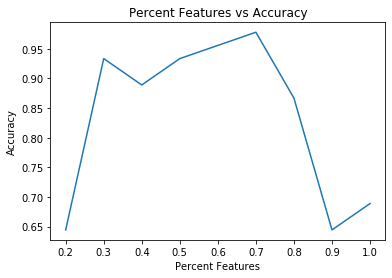

In [9]:
plt.plot(percent_features, acc)
plt.xlabel("Percent Features")
plt.ylabel("Accuracy")
plt.title("Percent Features vs Accuracy")
plt.show()